In [ ]:
import torch
import torch.nn as nn
from torchvision import models
from torchvision.models import mobilenet_v2
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

test_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
test_dataset = datasets.ImageFolder('/content/drive/MyDrive/pets/test', transform=test_transform)
print(f"Number of images in the test dataset: {len(test_dataset)}")
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

def test_model(model, test_loader, device, test_dataset_classes):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = correct / total
    print(f"Test Accuracy: {accuracy * 100:.2f}%")

    print(classification_report(all_labels, all_preds, target_names=test_dataset_classes))

    cm_finetuned = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_finetuned, annot=True, fmt='d', xticklabels=test_dataset_classes, yticklabels=test_dataset_classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix for Finetuned Student Model')
    plt.show()
    return np.array(all_preds), np.array(all_labels)


Number of images in the test dataset: 5000


#RESNET50

In [ ]:
import torchvision.models as models
import torch.nn as nn
import torch

# Define the path to your saved finetuned teacher model checkpoint
finetuned_checkpoint_path = save_path

# Load a standard ResNet50 model structure
teacher_model = models.resnet50(weights=None) # Load without pretrained ImageNet weights initially

# Modify the final fully connected layer to match the number of classes
num_ftrs = teacher_model.fc.in_features
num_classes = 2  # Your model was finetuned for 2 classes (Cat/Dog)
teacher_model.fc = nn.Linear(num_ftrs, num_classes)


# Load the state dictionary from the saved finetuned teacher model checkpoint
# Using map_location='cpu' to load onto CPU first is safer, then move to device
teacher_state_dict = torch.load(finetuned_checkpoint_path, map_location='cpu')

# Load the state dictionary into the standard ResNet50 model
# This should now work because the model structure matches the saved state_dict
teacher_model.load_state_dict(teacher_state_dict)

# Set the teacher model to evaluation mode
teacher_model.eval()

# Determine the device based on CUDA availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the teacher model to the device
teacher_model = teacher_model.to(device)

print("Finetuned teacher model loaded correctly for testing.")

Finetuned teacher model loaded correctly for testing.


In [ ]:
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms, datasets
import torch

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
test_dataset = datasets.ImageFolder('/content/drive/MyDrive/pets/test', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
num_images = len(test_dataset)
print(f"Number of images in the test dataset: {num_images}")

Number of images in the test dataset: 5000


In [ ]:
import numpy as np

def test_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = correct / total
    print(f" Test Accuracy: {accuracy * 100:.2f}%")
    return np.array(all_preds), np.array(all_labels)

In [ ]:
preds, labels = test_model(teacher_model, test_loader, device)


 Test Accuracy: 92.62%


              precision    recall  f1-score   support

         Cat       0.97      0.88      0.92      2500
         Dog       0.89      0.98      0.93      2500

    accuracy                           0.93      5000
   macro avg       0.93      0.93      0.93      5000
weighted avg       0.93      0.93      0.93      5000



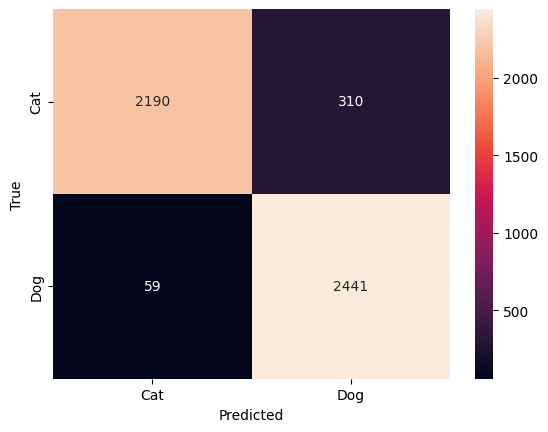

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print(classification_report(labels, preds, target_names=test_dataset.classes))

cm = confusion_matrix(labels, preds)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


##With normalized data

In [ ]:
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms, datasets
import torch

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Add normalization
                         std=[0.229, 0.224, 0.225])   # Add normalization
])
test_dataset = datasets.ImageFolder('/content/drive/MyDrive/pets/test', transform=transform)
print(f"Number of images in the test dataset: {len(test_dataset)}")
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Number of images in the test dataset: 5000


In [ ]:
preds, labels = test_model(teacher_model, test_loader, device)

 Test Accuracy: 98.44%


              precision    recall  f1-score   support

         Cat       0.99      0.98      0.98      2500
         Dog       0.98      0.99      0.98      2500

    accuracy                           0.98      5000
   macro avg       0.98      0.98      0.98      5000
weighted avg       0.98      0.98      0.98      5000



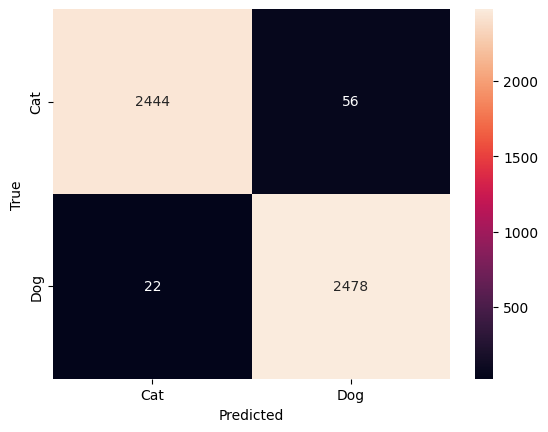

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print(classification_report(labels, preds, target_names=test_dataset.classes))

cm = confusion_matrix(labels, preds)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


#SIMCLR 3000

Best finetuned student model loaded.
Test Accuracy: 71.68%
              precision    recall  f1-score   support

         Cat       0.72      0.71      0.72      2500
         Dog       0.72      0.72      0.72      2500

    accuracy                           0.72      5000
   macro avg       0.72      0.72      0.72      5000
weighted avg       0.72      0.72      0.72      5000



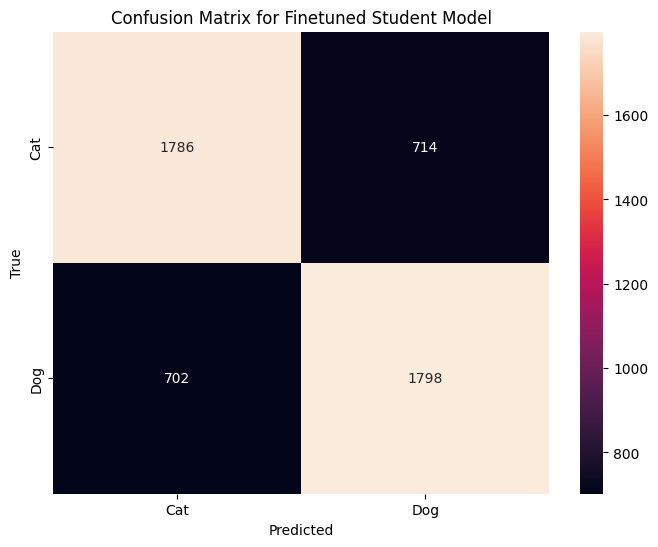

(array([0, 0, 0, ..., 1, 1, 1]), array([0, 0, 0, ..., 1, 1, 1]))

In [ ]:
# Determine the device based on CUDA availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the best finetuned student model
best_student_finetuned_path = '/content/drive/MyDrive/CatDogCNN/mods/student_finetuned_3000.pth'

# Create a standard MobileNetV2 model with the classifier
student_test = mobilenet_v2(weights=None)
num_ftrs_test = student_test.classifier[1].in_features
student_test.classifier[1] = nn.Linear(num_ftrs_test, 2) # 2 classes: cat, dog

# Load the saved state dictionary
student_test.load_state_dict(torch.load(best_student_finetuned_path, map_location=torch.device('cpu')))
#student_test.to(device)
student_test.eval() # Set the model to evaluation mode

print("Best finetuned student model loaded.")

test_model(student_test, test_loader, device, test_dataset.classes)

#SIMCLR 6000

Best finetuned student model loaded.
Test Accuracy: 75.90%
              precision    recall  f1-score   support

         Cat       0.79      0.71      0.75      2500
         Dog       0.73      0.81      0.77      2500

    accuracy                           0.76      5000
   macro avg       0.76      0.76      0.76      5000
weighted avg       0.76      0.76      0.76      5000



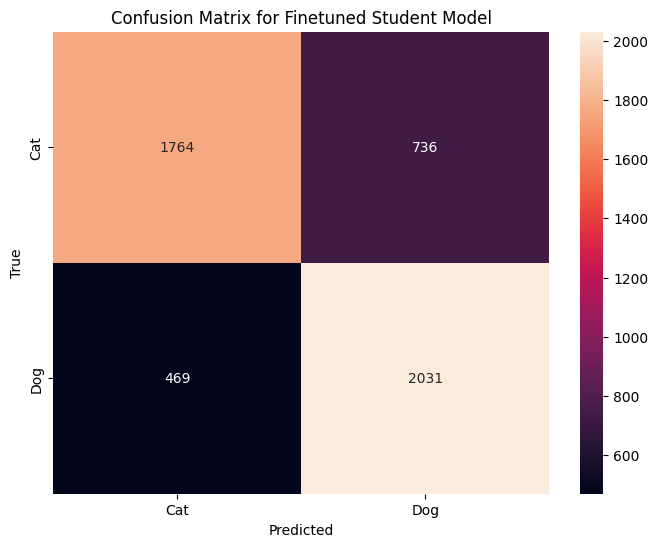

(array([1, 1, 0, ..., 0, 1, 1]), array([0, 0, 0, ..., 1, 1, 1]))

In [ ]:
# Load the best finetuned student model
best_student_finetuned_path = '/content/drive/MyDrive/mods/student_finetuned_6000_epoch.pth'

# Create a standard MobileNetV2 model with the classifier
student_test = mobilenet_v2(weights=None)
num_ftrs_test = student_test.classifier[1].in_features
student_test.classifier[1] = nn.Linear(num_ftrs_test, 2) # 2 classes: cat, dog

# Load the saved state dictionary
student_test.load_state_dict(torch.load(best_student_finetuned_path, map_location=torch.device('cpu')))
student_test.eval() # Set the model to evaluation mode

print("Best finetuned student model loaded.")

test_model(student_test, test_loader, device, test_dataset.classes)

#SIMCLR 10000

In [ ]:
# Load the best finetuned student model
best_student_finetuned_path = '/content/drive/MyDrive/mods/student_finetuned_10000_cont2.pth'

# Create a standard MobileNetV2 model with the classifier
student_test = mobilenet_v2(weights=None)
num_ftrs_test = student_test.classifier[1].in_features
student_test.classifier[1] = nn.Linear(num_ftrs_test, 2) # 2 classes: cat, dog

# Load the saved state dictionary
student_test.load_state_dict(torch.load(best_student_finetuned_path, map_location=torch.device('cpu')))
#student_test.to(device)
student_test.eval() # Set the model to evaluation mode

print("Best finetuned student model loaded.")

Best finetuned student model loaded.


In [ ]:
# Use the existing test_model function to get predictions and labels
preds_finetuned, labels_finetuned = test_model(student_test, test_loader)

 Test Accuracy: 82.74%


              precision    recall  f1-score   support

         Cat       0.87      0.78      0.82      2500
         Dog       0.80      0.88      0.84      2500

    accuracy                           0.83      5000
   macro avg       0.83      0.83      0.83      5000
weighted avg       0.83      0.83      0.83      5000



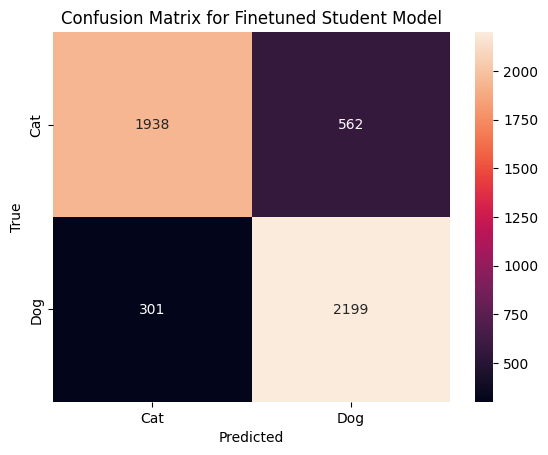

In [ ]:
# Use the existing classification_report and confusion_matrix code
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np # Import numpy if not already imported

print(classification_report(labels_finetuned, preds_finetuned, target_names=test_dataset.classes))

cm_finetuned = confusion_matrix(labels_finetuned, preds_finetuned)
sns.heatmap(cm_finetuned, annot=True, fmt='d', xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Finetuned Student Model')
plt.show()

#KD 3000

In [ ]:
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F

# Student (MobileNetV2)
student = models.mobilenet_v2(weights=None)
student.classifier[1] = nn.Linear(student.last_channel, 2)  # 2 classes

# Load SimCLR-pretrained weights if available
# Modified to load on CPU if CUDA is not available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the state dictionary
simclr_state_dict = torch.load('/content/drive/MyDrive/mods/only_distilled_student_3000.pth', map_location=device)

# Use strict=False because we are not loading the projection head keys
student.load_state_dict(simclr_state_dict, strict=True)


student = student.to(device)


In [ ]:
preds, labels = test_model(student, test_loader, device)


 Test Accuracy: 75.00%


              precision    recall  f1-score   support

         Cat       0.79      0.69      0.73      2500
         Dog       0.72      0.81      0.76      2500

    accuracy                           0.75      5000
   macro avg       0.75      0.75      0.75      5000
weighted avg       0.75      0.75      0.75      5000



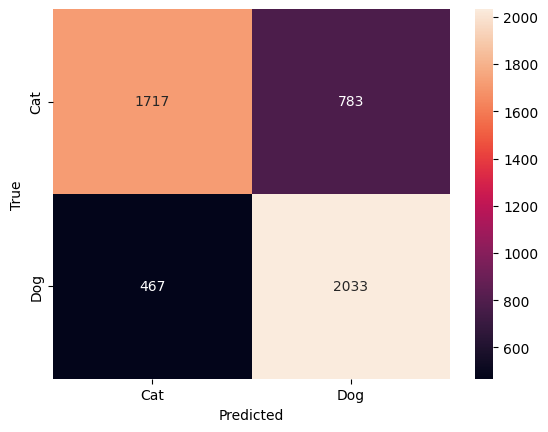

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print(classification_report(labels, preds, target_names=test_dataset.classes))

cm = confusion_matrix(labels, preds)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


#KD 6000

In [ ]:
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F

# Student (MobileNetV2)
student = models.mobilenet_v2(weights=None)
student.classifier[1] = nn.Linear(student.last_channel, 2)  # 2 classes

# Load SimCLR-pretrained weights if available
# Modified to load on CPU if CUDA is not available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the state dictionary
simclr_state_dict = torch.load('/content/drive/MyDrive/mods/only_distilled_student_6000.pth', map_location=device)

# Use strict=False because we are not loading the projection head keys
student.load_state_dict(simclr_state_dict, strict=True)


student = student.to(device)


In [ ]:
preds, labels = test_model(student, test_loader, device)


 Test Accuracy: 83.62%


              precision    recall  f1-score   support

         Cat       0.93      0.73      0.82      2500
         Dog       0.78      0.94      0.85      2500

    accuracy                           0.84      5000
   macro avg       0.85      0.84      0.83      5000
weighted avg       0.85      0.84      0.83      5000



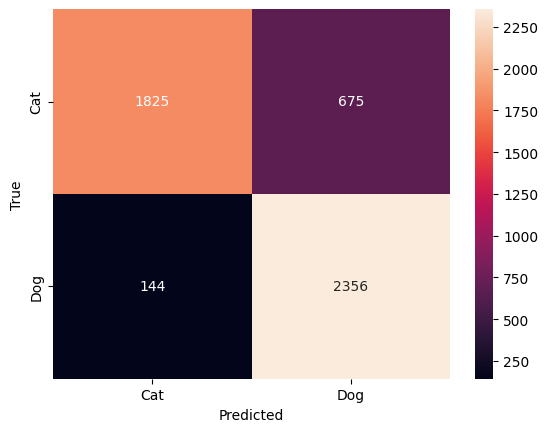

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print(classification_report(labels, preds, target_names=test_dataset.classes))

cm = confusion_matrix(labels, preds)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


#KD 10000

In [ ]:
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F

# Student (MobileNetV2)
student = models.mobilenet_v2(weights=None)
student.classifier[1] = nn.Linear(student.last_channel, 2)  # 2 classes

# Load SimCLR-pretrained weights if available
# Modified to load on CPU if CUDA is not available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the state dictionary
simclr_state_dict = torch.load('/content/drive/MyDrive/mods/only_distilled_student_10000_epoch.pth', map_location=device)

# Use strict=False because we are not loading the projection head keys
student.load_state_dict(simclr_state_dict, strict=True)


student = student.to(device)


In [ ]:
preds, labels = test_student(student, test_loader, device)


 Test Accuracy: 91.84%


              precision    recall  f1-score   support

         Cat       0.94      0.90      0.92      2500
         Dog       0.90      0.94      0.92      2500

    accuracy                           0.92      5000
   macro avg       0.92      0.92      0.92      5000
weighted avg       0.92      0.92      0.92      5000



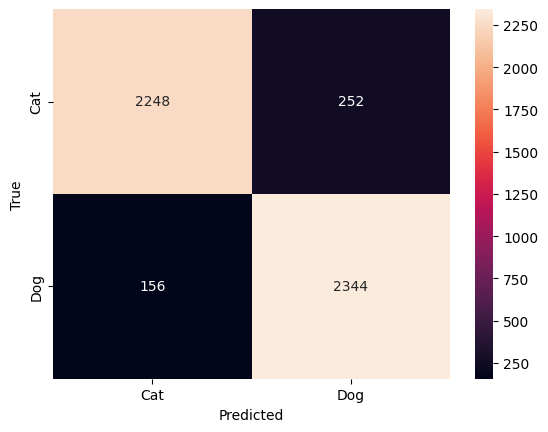

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print(classification_report(labels, preds, target_names=test_dataset.classes))

cm = confusion_matrix(labels, preds)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
